In [28]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

## Problem Statement

In this problem, I want to use the 24 hours’ bitcoin orice from the previous day to generate the next day’s 24 hours’ number.

In [11]:
data = yf.download('BTC-USD', start="2021-01-01", end="2021-10-31", interval = "1D")
data.sample(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-23,51739.808594,52120.792969,47714.664062,51093.652344,51093.652344,86668667320
2021-09-17,47771.003906,48160.921875,46832.523438,47267.519531,47267.519531,28727713711
2021-07-22,32138.873047,32576.400391,31745.298828,32313.105469,32313.105469,19555230518
2021-09-27,43234.183594,44313.246094,42190.632812,42235.730469,42235.730469,30980029059
2021-08-21,49327.074219,49717.019531,48312.199219,48905.492188,48905.492188,40585205312
2021-09-02,48807.847656,50343.421875,48652.320312,49327.722656,49327.722656,39508070319
2021-01-25,32285.798828,34802.742188,32087.787109,32366.392578,32366.392578,59897054838
2021-06-08,33589.519531,34017.386719,31114.443359,33472.632812,33472.632812,49902050442
2021-03-26,51683.011719,55137.312500,51579.855469,55137.312500,55137.312500,56652197978


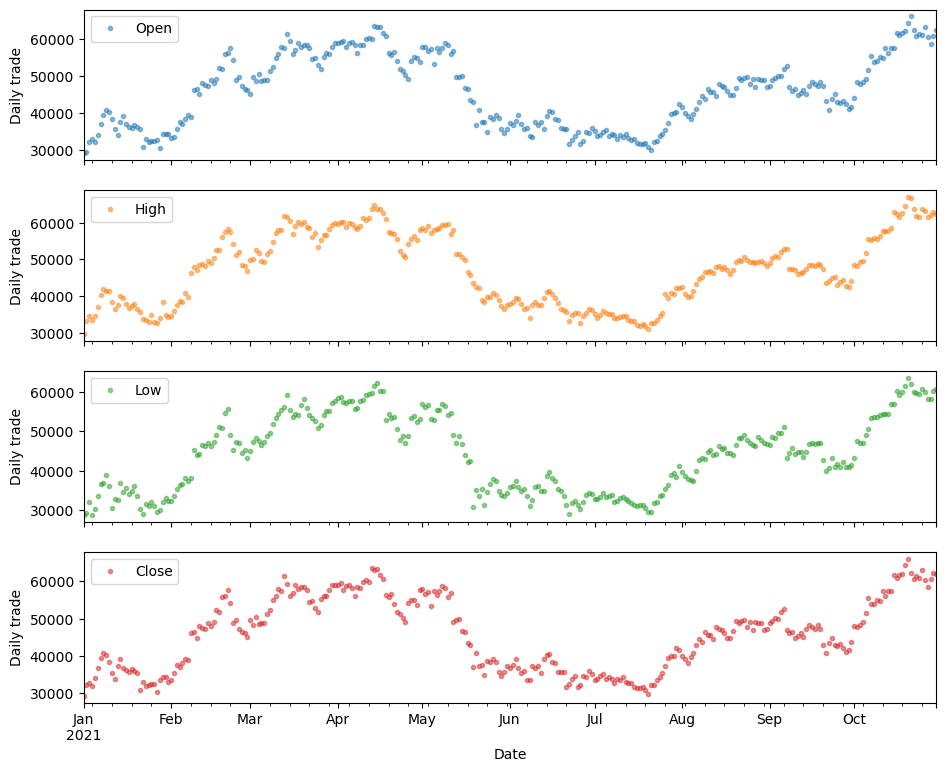

In [12]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

In [15]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2021-10-26,63032.761719,63229.027344,59991.160156,60363.792969,60363.792969,34878965587
2021-10-27,60352.000000,61435.183594,58208.187500,58482.386719,58482.386719,43657076893
2021-10-28,58470.730469,62128.632812,58206.917969,60622.136719,60622.136719,45257083247


In [24]:
df= data
X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

160
41


In [26]:
model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=10,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
4/4 [==============================] - 11s 895ms/step - loss: 0.2305 - mse: 0.2305 - mae: 0.4191 - val_loss: 0.1671 - val_mse: 0.1671 - val_mae: 0.3564
Epoch 2/40
4/4 [==============================] - 0s 40ms/step - loss: 0.1542 - mse: 0.1542 - mae: 0.3423 - val_loss: 0.0865 - val_mse: 0.0865 - val_mae: 0.2432
Epoch 3/40
4/4 [==============================] - 0s 39ms/step - loss: 0.0945 - mse: 0.0945 - mae: 0.2435 - val_loss: 0.1241 - val_mse: 0.1241 - val_mae: 0.3007
Epoch 4/40
4/4 [==============================] - 0s 34ms/step - loss: 0.0701 - mse: 0.0701 - mae: 0.2184 - val_loss: 0.0641 - val_mse: 0.0641 - val_mae: 0.2045
Epoch 5/40
4/4 [==============================] - 0s 35ms/step - loss: 0.0665 - mse: 0.0665 - mae: 0.2169 - val_loss: 0.0687 - val_mse: 0.0687 - val_mae: 0.2103
Epoch 6/40
4/4 [==============================] - 0s 71ms/step - loss: 0.0560 - mse: 0.0560 - mae: 0.1938 - val_loss: 0.0730 - val_mse: 0.0730 - val_mae: 0.2173
Epoch 7/40
4/4 [================

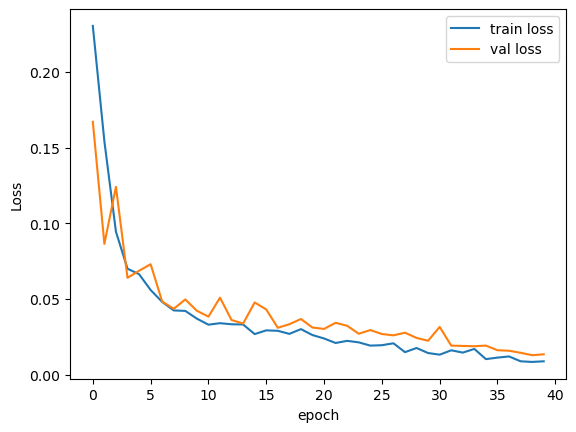

In [29]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

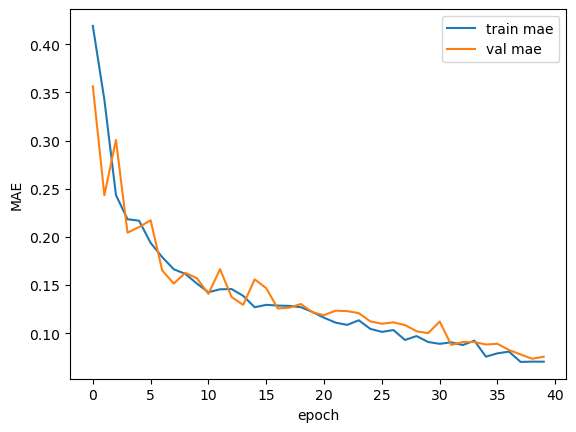

In [30]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 98, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 49, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 47, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 23, 128)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 21, 64)       

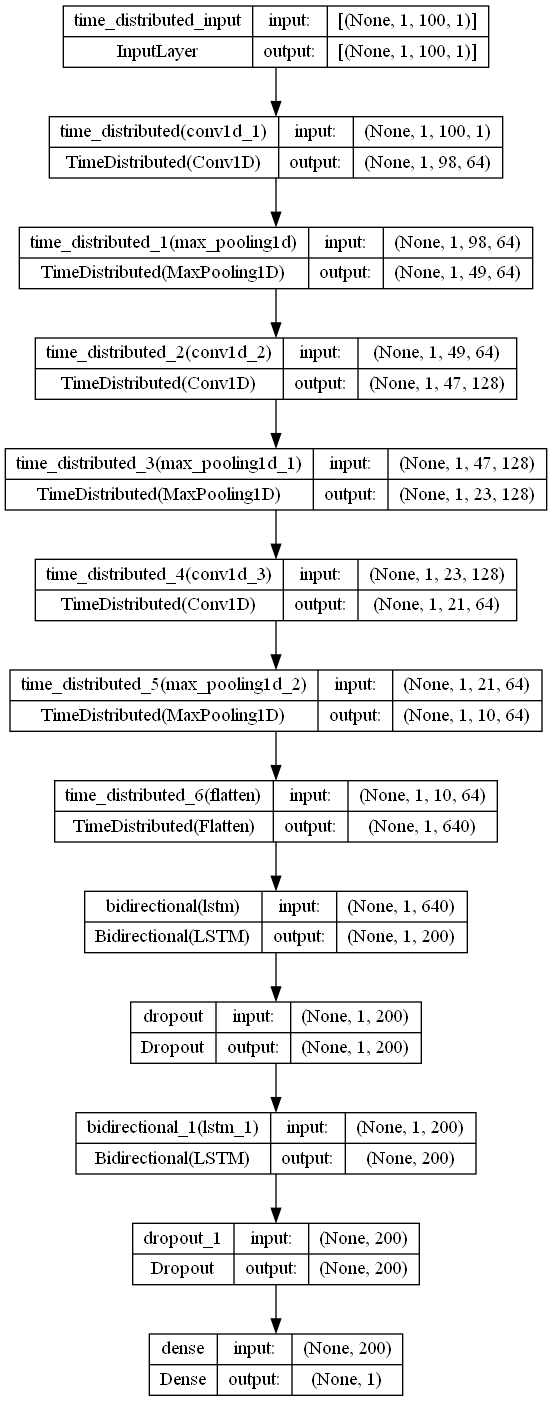

In [31]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

2/2 [==============================] - 1s 5ms/step


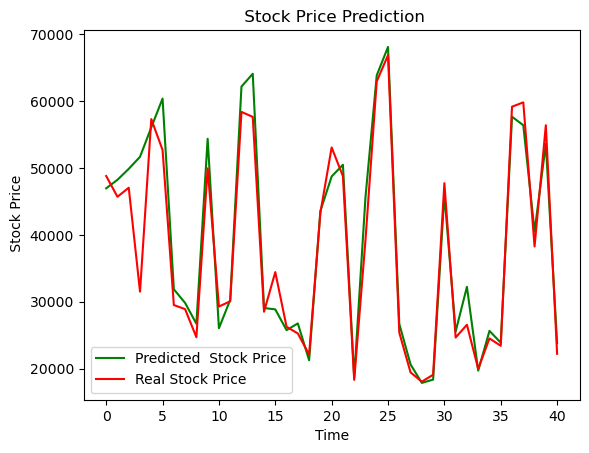

In [32]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()